# Preamble

In [147]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import pandas as pd
plt.style.use(astropy_mpl_style)


# Question 1

Filename: m81.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  1             1 PrimaryHDU     268   (495, 494)   float32   


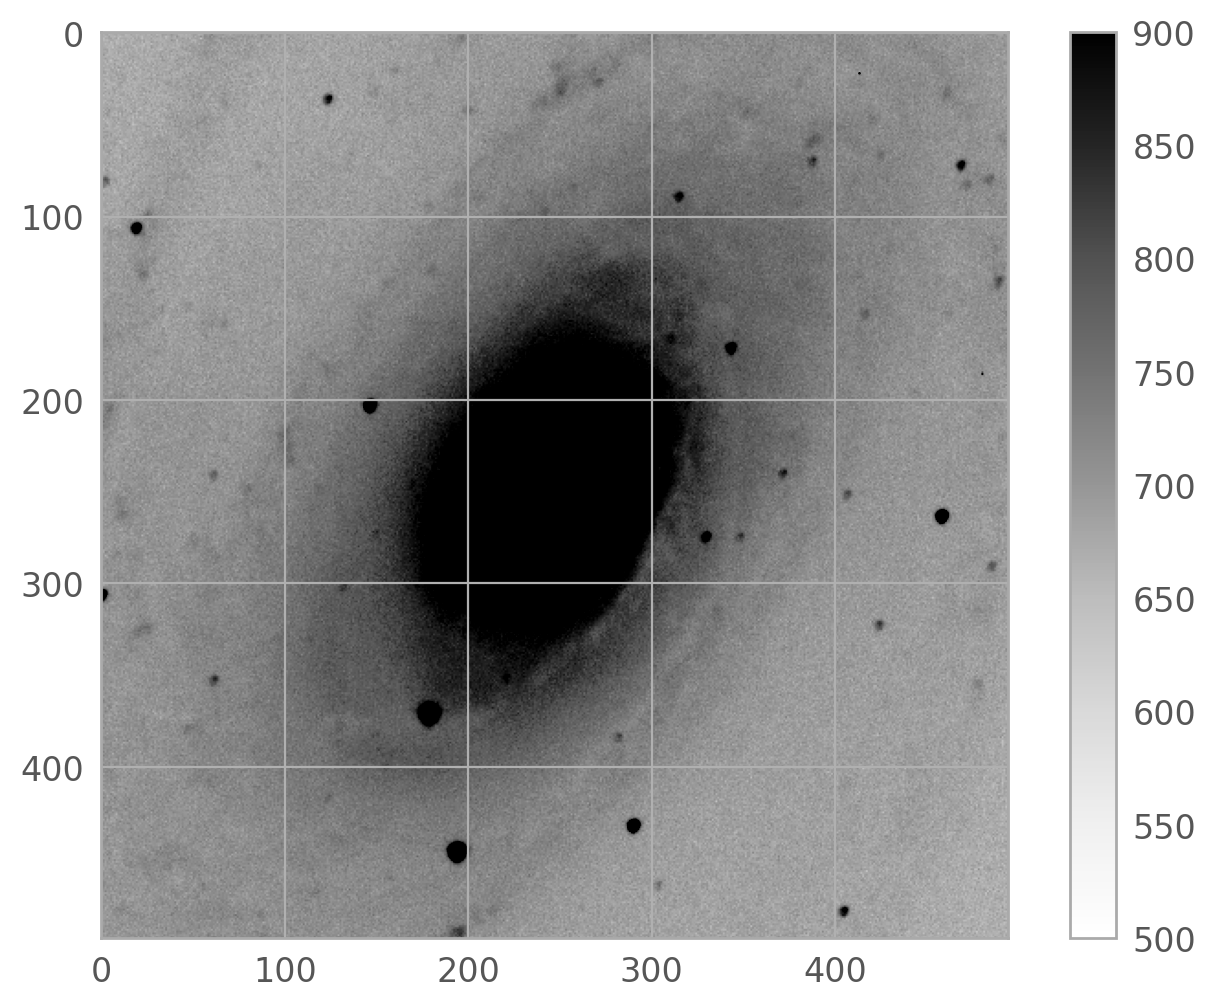

In [148]:
# downloaded an image of m81 from the website
# https://irsa.ipac.caltech.edu/applications/ztf/?__action=layout.showDropDown&
# and stored that image in the same directory as this file under this name
m81_file_name = 'm81.fits'

# extract image data from the file
image_data = fits.getdata(m81_file_name, ext=0)

# plot the image
plt.figure(figsize = (8, 6), dpi=200)
plt.imshow(image_data, cmap='Greys', vmin=500, vmax=900)
plt.colorbar()

In [149]:
fits.info(m81_file_name)

Filename: m81.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  1             1 PrimaryHDU     268   (495, 494)   float32   


# Question 2

In [96]:
def find_streak(data_arr, threshold = 15000):
    found_streaks = False
    
    # try to find horizontal streaks
    # get all the rows with values larger than the threshold
    bool_row_arr = np.all(data_arr > threshold, axis = 1)
    streak_row_arr = np.array(np.where(bool_row_arr == True)).flatten()
    if len(streak_row_arr) > 0:
        found_streaks = True
        print(f"Horizontal streaks found at: {streak_row_arr}")
    
    # try to find vertical streaks
    # get all the columns with values larger than the threshold
    bool_col_arr = np.all(data_arr > threshold, axis = 0)
    streak_col_arr = np.array(np.where(bool_col_arr == True)).flatten()
    if len(streak_col_arr) > 0:
        found_streaks = True
        print(f"Vertical streaks found at: {streak_col_arr}")
    return found_streaks

In [97]:
# simulate two images with simple lines of different values across the image
x = np.arange(-3, 3, 1)
y = np.arange(-3, 3, 1)

# X has vertical streaks, Y has horizontal streaks
X, Y = np.meshgrid(x, y)

Vertical streaks found at: [4 5]


True

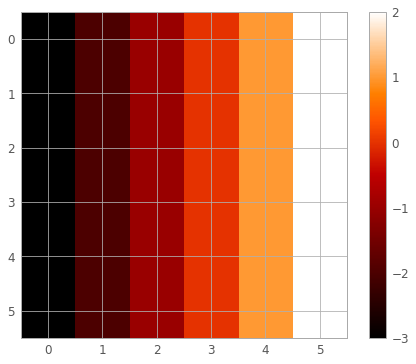

In [98]:
plt.imshow(X)
plt.colorbar()
find_streak(X, threshold = 0)
# at [4, 5], the streaks are of value 1 and 2 and are therefore detected by the algorithm

Horizontal streaks found at: [2 3 4 5]


True

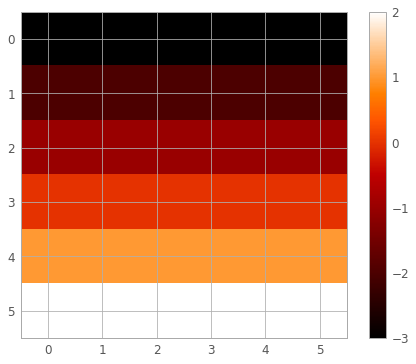

In [99]:
plt.imshow(Y)
plt.colorbar()
find_streak(Y, threshold = -2)
# at [2, 3, 4, 5], the streaks are of value -1, 0, 1 and 2 and are therefore detected by the algorithm

# Question 3

Currently we are considering images that are either:
1) background + noise only, or 

2) background + streak + noise. 

We assume the streak will appear brighter than the background, having a mean brightness of $\mu_s$. Each pixel's brightness, after subtracting the background brightness, has mean value $0$, and is subject to an identical and independent Gaussian distribution of noises with standard deviation $\sigma_n$. 

Then, each pixel has some probability to reach brightness $\mu_s$. Let the ratio of the number of pixels that has brightness above $\mu_s$, $S$, over the total number of pixels $T = N*N$ (since we are dealing with a $N \times N$ grid, be $r = S/T$.

Hence, with parameter $r$, we can distinguish between images with streaks, corresponding to a large $r$, and images without streaks, corresponding to a small $r$. 

The threshold is then dependent of the maximum number of pixels reaching brightness $\mu_s$ purely due to noise in images without streaks. Define random variable $M = \text{max}(S)$ which represents the maximum number of pixels reaching brightness $\mu_s$ purely due to noise in a $N \times N$ grid. $M$ follows a distribution that could be described by the Generalized Extreme Value Distribution $f(M)$. 

Its probability density function is:

$f(M) = (\frac{1}{\sigma})\text{exp}(-(1 + k\frac{x-\mu}{\sigma})^{-\frac{1}{k}})(1 + k\frac{x - \mu}{\sigma})^{-1-\frac{1}{k}}$

where $\mu$ is the location parameter, $\sigma$ is the scale parameter, and $k \neq 0$ is the shape parameter.

We can derive the parameters in $f(M)$ by obtaining $N$ and $\sigma_n$. Obtaining $f(M)$ is crucial to determining the threshold since we can obtain the CDF $F(M)$ of this distribution by integrating $f(M)$. By choosing a threshold $M_T$, we can limit the false alarm rate $R_{FA}$, which will be $R_{FA} = 1 - F(M_T)$ since all values below $M_T$ will be disregarded, and only a proportion of $R_{FA}$ of a batch of samples will exceed $M_T$.

We can of course also infer the threshold by choosing a false alarm rate, simply by obtaining the inverse of the CDF and obtaining $F^{-1}(R_{FA})$, and plugging in the desired $R_{FA}$ to obtain the corresponding threshold $M_T = F^{-1}(R_{FA})$.

# Question 4

In [135]:
from ztfquery import query
zquery = query.ZTFQuery()

# Check what are the Julian Dates of March 27 2018 and March 30 2018
from astropy import time
jdstart = time.Time("2018-03-27").jd
jdend = time.Time("2018-03-30").jd 

# Do the Query to see what exists
zquery.load_metadata(sql_query=f"seeing<2 and obsjd BETWEEN {jdstart} AND {jdend}") # this may take some time.

In [136]:
zquery.metatable 

,ra,dec,infobits,field,ccdid,qid,rcid,fid,filtercode,pid,...,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,ipac_pub_date,ipac_gid
0,148.563820,37.255422,0,711,3,4,11,1,zg,451229981115,...,149.106164,37.690186,148.014368,37.684615,148.027727,36.818229,149.106584,36.823972,2019-05-08 00:00:00+00,1
1,146.232945,37.218011,0,711,4,4,15,1,zg,451229981515,...,146.759756,37.664432,145.669201,37.634847,145.712275,36.769308,146.790046,36.798632,2019-05-08 00:00:00+00,1
2,146.195639,38.083788,0,711,4,1,12,1,zg,451229981215,...,146.728236,38.530039,145.624941,38.500272,145.669256,37.634834,146.759725,37.664403,2019-05-08 00:00:00+00,1
3,152.352024,60.765970,0,817,7,4,27,1,zg,451251202715,...,153.232915,61.203940,151.439582,61.188520,151.495006,60.322527,153.239872,60.337674,2019-05-08 00:00:00+00,1
4,148.552604,60.680393,0,817,8,4,31,1,zg,451251203115,...,149.376116,61.143002,147.592937,61.075717,147.752466,60.212988,149.488094,60.278543,2019-05-08 00:00:00+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,289.057258,-5.079412,0,437,4,1,12,1,zg,452530591215,...,289.492244,-4.648042,288.625457,-4.644412,288.621460,-5.510798,289.489588,-5.514357,2019-05-08 00:00:00+00,1
14821,290.050915,-5.949645,0,437,3,3,10,1,zg,452530591015,...,290.487156,-5.518288,289.618953,-5.514041,289.614287,-6.380432,290.483512,-6.384955,2019-05-08 00:00:00+00,1
14822,290.920330,-5.953408,0,437,3,4,11,1,zg,452530591115,...,291.355932,-5.521463,290.487727,-5.518322,290.484094,-6.384975,291.353365,-6.388025,2019-05-08 00:00:00+00,1
14823,291.914575,-4.041234,0,437,6,3,22,1,zg,452530592215,...,292.347878,-3.608191,291.481832,-3.607356,291.481061,-4.473916,292.347760,-4.474825,2019-05-08 00:00:00+00,1


In [142]:
# save the RA and DEC data to a local file on disk for future use
zquery.metatable[["ra", "dec"]].to_csv('dled_180327_180330.csv')

In [146]:
# in the future, can simply import this .csv file into pandas
future_metatable = pd.read_csv('dled_180327_180330.csv')
future_metatable

,Unnamed: 0,ra,dec
0,0,148.563820,37.255422
1,1,146.232945,37.218011
2,2,146.195639,38.083788
3,3,152.352024,60.765970
4,4,148.552604,60.680393
...,...,...,...
14820,14820,289.057258,-5.079412
14821,14821,290.050915,-5.949645
14822,14822,290.920330,-5.953408
14823,14823,291.914575,-4.041234


In [106]:
# Do the Query to try to find m81 which is located at 
# RA = 149.52965770, Dec = 68.86053233
# and discovered after March 27, 2018

starttime = time.Time("2018-03-27").jd
zquery.load_metadata(radec=[149.52965770,68.86053233], size=0.01, sql_query=f"fid=3 and obsjd>{starttime}")


In [107]:
zquery.metatable[["ra", "dec"]]

,ra,dec
0,150.015086,68.813983
1,149.513410,68.892506
2,150.457802,68.927947
3,149.512815,68.892916


In [117]:
# We obtained 4 candidate images, now download them
zquery.download_data("sciimg.fits", show_progress=True, verbose = True)

/Users/yauckwilliam/miniconda3/lib/python3.8/site-packages/ztfquery/io.py:643: UserWarning: No parallel downloading
  warnings.warn("No parallel downloading")
/Users/yauckwilliam/miniconda3/lib/python3.8/site-packages/ztfquery/io.py:696: UserWarning: downloading https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0208/291250/ztf_20200208291250_001849_zi_c16_o_q2_sciimg.fits to ./Data/sci/2020/0208/291250/ztf_20200208291250_001849_zi_c16_o_q2_sciimg.fits
  warnings.warn("downloading %s to %s"%(url,fileout))


FloatProgress(value=0.0)

/Users/yauckwilliam/miniconda3/lib/python3.8/site-packages/ztfquery/io.py:696: UserWarning: downloading https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0523/194178/ztf_20180523194178_000841_zi_c06_o_q1_sciimg.fits to ./Data/sci/2018/0523/194178/ztf_20180523194178_000841_zi_c06_o_q1_sciimg.fits
  warnings.warn("downloading %s to %s"%(url,fileout))


FloatProgress(value=0.0)

/Users/yauckwilliam/miniconda3/lib/python3.8/site-packages/ztfquery/io.py:696: UserWarning: downloading https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2020/0307/270949/ztf_20200307270949_001848_zi_c13_o_q2_sciimg.fits to ./Data/sci/2020/0307/270949/ztf_20200307270949_001848_zi_c13_o_q2_sciimg.fits
  warnings.warn("downloading %s to %s"%(url,fileout))


FloatProgress(value=0.0)

/Users/yauckwilliam/miniconda3/lib/python3.8/site-packages/ztfquery/io.py:696: UserWarning: downloading https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0523/186887/ztf_20180523186887_000841_zi_c06_o_q1_sciimg.fits to ./Data/sci/2018/0523/186887/ztf_20180523186887_000841_zi_c06_o_q1_sciimg.fits
  warnings.warn("downloading %s to %s"%(url,fileout))


FloatProgress(value=0.0)


delayed


In [121]:
# retrieve the local data file path
zquery.get_local_data("sciimg.fits")

['./Data/sci/2020/0208/291250/ztf_20200208291250_001849_zi_c16_o_q2_sciimg.fits',
 './Data/sci/2018/0523/194178/ztf_20180523194178_000841_zi_c06_o_q1_sciimg.fits',
 './Data/sci/2020/0307/270949/ztf_20200307270949_001848_zi_c13_o_q2_sciimg.fits',
 './Data/sci/2018/0523/186887/ztf_20180523186887_000841_zi_c06_o_q1_sciimg.fits']

In [132]:
# Show the image
m81_dled_file_name = './Data/sci/2018/0523/186887/ztf_20180523186887_000841_zi_c06_o_q1_sciimg.fits'
fits.info(m81_dled_file_name)


Filename: ./Data/sci/2018/0523/186887/ztf_20180523186887_000841_zi_c06_o_q1_sciimg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  1             1 PrimaryHDU     268   (3072, 3080)   float32   


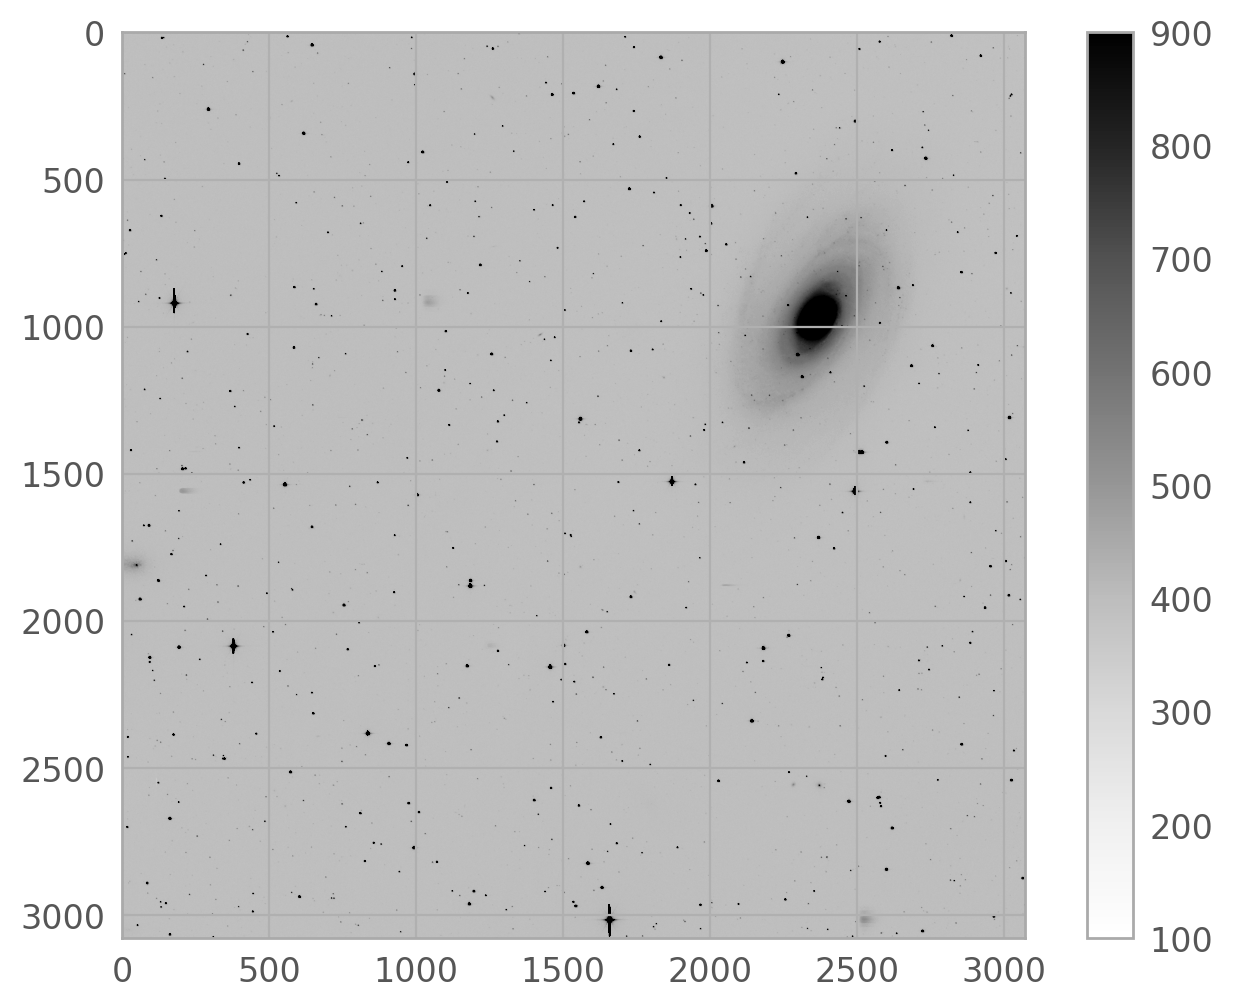

In [133]:
dl_image_data = fits.getdata(m81_dled_file_name, ext=0)
plt.figure(figsize = (8, 6), dpi=200)
plt.imshow(dl_image_data, cmap='Greys', vmin=100, vmax=900)
plt.colorbar()

# Question 5

We should look for geostationary satellites with declination 0 $\deg$, since geostationary satellites always remain on the celetial equatorial plane. Their right ascension varies but remain constant always.


The first order answer will not change since the equatorial coordinate system is independent of the observer's position on Earth. Declination is measured in degrees north or south of the celestial equator, while right ascension is measured eastward along the celestial equator from the vernal equinox to its intersection with the object's hour circle (the great circle passing through the object being considered and through the north celestial pole). 

Hence, we see that none of these geometrical objects are dependent on the observer's local position on the Earth. The only reference positions needed are the north celestial pole, the equator, and the vernal equinox, which are stationary in space.